# Lab03: Logistic Regression.

- Student ID: 21127122
- Student name: Hồ Thanh Nhân

**How to do your homework**


You will work directly on this notebook; the word `TODO` indicate the parts you need to do.

You can discuss ideas with classmates as well as finding information from the internet, book, etc...; but *this homework must be your*.

**How to submit your homework**

Before submitting, rerun the notebook (`Kernel` ->` Restart & Run All`).

Then create a folder named `ID` (for example, if your ID is 1234567, then name the folder `1234567`). Copy file notebook to this folder, compress and submit it on moodle.

**Contents:**
- Logistic Regression.

## 1. Feature Extraction

### Import Library

In [126]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report 

### Load data

In [127]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', return_X_y=True, parser='auto')

In [128]:
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


### Extract Features

So we basically have 70000 samples with each sample having 784 features - pixels in this case and a label - the digit the image represent.

Let’s play around and see if we can extract any features from the pixels that can be more informative. First I’d like to know more about average intensity - that is the average value of a pixel in an image for the different digits

In [129]:
labels=np.unique(y)
# print(labels)
n_label=np.unique(y).shape[0]
l_means=np.zeros(shape=n_label,dtype=float) #array stores average intensity for each label

#TODO compute average intensity for each label

for label in labels:
    l_means[int(label)] = np.mean(X[label == y])
    
print(l_means)

[44.17740512 19.40680177 38.03420776 36.15420938 30.99599983 32.95015873
 35.23486491 29.21798737 38.39790125 31.35940809]


Plot the average intensity using matplotlib

<BarContainer object of 10 artists>

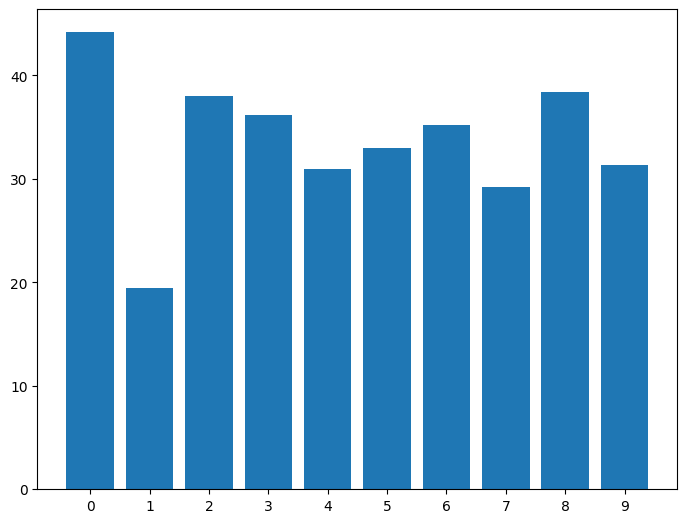

In [130]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(labels,l_means)

As we can see there are some differences in intensity. The digit “1” is the less intense while the digit “0” is the most intense. So this new feature seems to have some predictive value if you wanted to know if say your digit is a “1” or not.

In [131]:
#TODO compute average intensity for each data sample
intensity = np.mean(X, axis=1)
print(intensity.shape)

(70000,)

Sometimes people really do not know what are they doing. I am not an exception:

In [132]:
X = np.array(X.values)
X_flip=np.flip(X, axis=1)
symmetry= np.mean(abs(X-X_flip), axis=1)
print(symmetry.shape)

(70000,)


I called this feature "symmetry" (though it's not "symmetry" at all). Use visualization method to understand why this feature work.

Our new trainning data will have 70000 samples and 2 features: intensity, symmetry.

In [133]:
#TODO create X_new by horizontal stack intensity and symmetry
X_new = np.column_stack((intensity, symmetry))
print(X_new.shape) #it should be (70000,2)

(70000, 2)


## 2. Training 

Usually logistic regression is a good first choice for classification. In this homework we use logistic regression for classifying digit 1 images and not digit 1 images.

### Normalize data
First normalize data using Z-score normalization
- **TODO: Study about Z-score normalization**
- **TODO: Why should we normalize data?**

- **Z-Score Normalization** [1] [2]

Z-score normalization, also known as standard score normalization, is a technique used in statistics and machine learning to standardize the scale of features or variables. The goal is to transform the data such that the mean of the values is 0 and the standard deviation is 1.

We use the following formula to perform a z-score normalization on every value in a dataset:

$$Z\ Score = \frac{x - \mu}{\sigma}$$

Where:

$x: Original\ value$

$\mu: Mean\ of\ data$

$\sigma: Standard\ deviation\ of\ data$

- **Why should we normalize data?** [3] [4]

Normalizing a vector most often means dividing by a norm of the vector. It also often refers to rescaling by the minimum and range of the vector, to make all the elements lie between 0 and 1 thus bringing all the values of numeric columns in the dataset to a common scale.

Data normalization is a crucial step in data preprocessing, particularly in machine learning and statistics.

The goal of normalization is to change the values of numeric columns in the dataset to a common scale, without distorting differences in the ranges of values. For machine learning, every dataset does not require normalization. It is required only when features have different ranges.

- For example, consider a data set containing two features, age, and income(x2). Where age ranges from 0–100, while income ranges from 0–100,000 and higher. Income is about 1,000 times larger than age. So, these two features are in very different ranges. When we do further analysis, like multivariate linear regression, for example, the attributed income will intrinsically influence the result more due to its larger value. But this doesn’t necessarily mean it is more important as a predictor. So we normalize the data to bring all the variables to the same range.

**In Machine Learning:**

- Normalization in machine learning plays a really important part within the precision of calculations. Normalization makes a difference to scale features so that the information is inside a certain range, usually between 0 and 1. This guarantees that all features contribute equally to the analysis, otherwise it might lead to bias towards one include.

- Normalization in machine learning too helps in increasing the convergence rate of machine learning algorithms such as clustering, neural networks, and regression. Typically since the algorithms work better when the data points are near to each other and inside the same range. With normalization, the data points are more homogenous and the machine learning algorithm can learn and make more accurate predictions.

- Additionally, normalization makes a difference to decrease the sum of noise in the data. When the information is centered around a mean of zero, it'll be simpler to identify the vital designs and relationships. This will lead to better comes about and more exact predictions.

In [134]:
#TODO: normalize X_new
mean = np.mean(X_new, axis=0)
standard_deviation = np.std(X_new, axis=0)
X_new = (X_new - mean) / standard_deviation

### Construct  data

In [135]:
X_new = np.hstack((np.ones((len(X_new), 1)), X_new)) #stack 1s column as usual
y_new=y.astype(int)
y_new[y_new != 1] = 0 # digit 1 -> class 1, other digits -> class 0
y_new=np.array(y_new).reshape(-1,1)
print (X_new.shape)
print (y_new.shape)

(70000, 3)
(70000, 1)


### Split data 

In [136]:
train_X, test_X, train_y, test_y = train_test_split(X_new, y_new, test_size= int(1/3*X.shape[0]))
print(train_X.shape)
print(train_y.shape)

(46667, 3)
(46667, 1)


### Sigmoid function and derivative of the sigmoid function

In [137]:
def sigmoid_activation(x):
    """compute the sigmoid activation value for a given input"""
    # Clip the input values to a specific range to prevent overflow
    clipped_x = np.clip(x, -500, 500)
    
    # Compute the sigmoid using the clipped input (clipped_x)
    return 1.0 / (1 + np.exp(-clipped_x))
def sigmoid_deriv(x):
    '''compute the derivative of the sigmoid function ASSUMING
    that the input ‘x‘ has already been passed through the sigmoid
    activation function'''
    return x * (1 - x)

### Compute output

In [138]:
def compute_h(W, X):
    """
    Compute output: Take the dot product between our features ‘X‘ and the weight
    matrix ‘W‘, then pass this value through our sigmoid activation function 
    """
    return sigmoid_activation(X.dot(W))
def predict(W, X):
 
    '''Take the dot product between our features and weight matrix, 
       then pass this value through our sigmoid activation'''
    #........
    preds=sigmoid_activation(X.dot(W))
    # apply a step function to threshold the outputs to binary
    # class labels
    preds[preds <= 0.5] = 0
    preds[preds > 0] = 1

    return preds

### Compute gradient

**Loss Function: Average negative log likelihood**
$$\mathcal{L}=\dfrac{1}{N} \sum_{i=1}^{N} -\left(y^{i}\ln h_{\mathbf{w}}\left(\mathbf{x}^{i}\right)+\left(1-y^{i}\right)\ln \left(1-h_{\mathbf{w}}\left(x^{i}\right)\right)\right) $$


$$\text{Sigmoid Activation: } z= \sigma \left(h\right)= \dfrac{1}{1+e^{-h}}$$

$$\text{Cross-entropy: } J(w)=-\left({ylog(z)+(1-y)log(1-z)}\right)$$

$$\text{Chain rule: } \dfrac{\partial J(w)}{\partial w}=\dfrac{\partial J(w)}{\partial z} \dfrac{\partial z}{\partial h}\dfrac{\partial h}{\partial w}  $$

$$\dfrac{\partial J(w)}{\partial z}=-\left(\dfrac{y}{z}-\dfrac{1-y}{1-z}\right)=\dfrac{z-y}{z(1-z)}$$

$$\dfrac{\partial z}{\partial h}=z(1-z)$$

$$\dfrac{\partial h}{\partial w}=X$$

$$\dfrac{\partial J(w)}{\partial w}=X^T(z-y)$$

In [139]:
def compute_gradient(train_X, error):
    """
    This is the gradient descent update of "average negative loglikelihood" loss function. 
    In lab02 our loss function is "sum squared error".
    """
    #TODO
    gradient = train_X.T.dot(error)
    return gradient

In [150]:
def train(W,train_X, train_y, learning_rate, num_epochs, losses):
    # fixing "divide by zero encountered in log"
    epsilon = 1e-16
    train_y = np.clip(train_y, epsilon, 1 - epsilon)
    for epoch in np.arange(0, num_epochs):
        h=compute_h(W,train_X)
        h = np.clip(h, epsilon, 1 - epsilon)
        error = h - train_y
        loss = np.mean(- train_y * np.log(h) - (1 - train_y) * np.log(1 - h))
        losses.append(loss)
        gradient=compute_gradient(train_X, error)
        W += -learning_rate * gradient
        if ((epoch+1)%1000==0): print ('Epoch %d, loss %.3f' %(epoch+1, loss))
        
    return W

### Train our model

In [151]:
W = np.random.randn(train_X.shape[1], 1)
losses=[]
num_epochs=40000
learning_rate=0.01
W=train(W,train_X, train_y, learning_rate, num_epochs , losses)
x_preds=predict(W ,train_X)
train_err = np.mean(x_preds != train_y) * 100
print ('=' * 50)
print ('Train err of final w: ', train_err)

Epoch 1000, loss 2.141
Epoch 2000, loss 2.141
Epoch 3000, loss 2.141
Epoch 4000, loss 2.141
Epoch 5000, loss 2.141
Epoch 6000, loss 2.141
Epoch 7000, loss 2.141
Epoch 8000, loss 2.141
Epoch 9000, loss 2.141
Epoch 10000, loss 2.141
Epoch 11000, loss 2.141
Epoch 12000, loss 2.141
Epoch 13000, loss 2.141
Epoch 14000, loss 2.141
Epoch 15000, loss 2.141
Epoch 16000, loss 2.141
Epoch 17000, loss 2.141
Epoch 18000, loss 2.141
Epoch 19000, loss 2.141
Epoch 20000, loss 2.141
Epoch 21000, loss 2.141
Epoch 22000, loss 2.141
Epoch 23000, loss 2.141
Epoch 24000, loss 2.141
Epoch 25000, loss 2.141
Epoch 26000, loss 2.141
Epoch 27000, loss 2.141
Epoch 28000, loss 2.141
Epoch 29000, loss 2.141
Epoch 30000, loss 2.141
Epoch 31000, loss 2.141
Epoch 32000, loss 2.141
Epoch 33000, loss 2.141
Epoch 34000, loss 2.141
Epoch 35000, loss 2.141
Epoch 36000, loss 2.141
Epoch 37000, loss 2.141
Epoch 38000, loss 2.141
Epoch 39000, loss 2.141
Epoch 40000, loss 2.141
Train err of final w:  6.634238326869093


## 3. Evaluate our model

In [142]:
preds = predict(W, train_X)
print(classification_report(train_y, preds))

              precision    recall  f1-score   support

           0       0.99      0.92      0.95     41373
           1       0.59      0.92      0.72      5294

    accuracy                           0.92     46667
   macro avg       0.79      0.92      0.84     46667
weighted avg       0.94      0.92      0.93     46667



In [143]:
preds = predict(W, test_X)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.99      0.92      0.95     20750
           1       0.59      0.93      0.72      2583

    accuracy                           0.92     23333
   macro avg       0.79      0.92      0.84     23333
weighted avg       0.95      0.92      0.93     23333



**TODO: Comment on the result**

- The Logistic Regression model employed is a binary classification algorithm utilized to classify handwritten digits within the widely used MNIST_784 dataset. This dataset consists of 70,000 grayscale images depicting digits ranging from 0 to 9, each with dimensions of 28x28 pixels. The features used for training are obtained by horizontally stacking attributes related to intensity and symmetry extracted from the dataset. To standardize the values of these features, the Z-score normalization technique is applied. The model is trained using the Logistic Regression algorithm with gradient descent optimization.

- The Logistic Regression model aims to classify handwritten digits into two categories: digit "1" and non-digit "0". By leveraging features extracted from intensity and symmetry attributes, the model attempts to differentiate between these categories based on the given dataset.

- The evaluation of the Logistic Regression model on both the training and test datasets demonstrates consistent performance across various metrics. For the training dataset, class 0 exhibits high precision, recall, and F1-scores (99%, 92%, 95% respectively), while class 1 shows moderate precision (59%) but strong recall and F1-score (92%, 72% respectively). The overall accuracy on the training set stands at 92%. Similarly, on the test dataset, class 0 maintains high precision, recall, and F1-scores (99%, 92%, 95%), while class 1 displays slightly lower precision (59%) yet strong recall and F1-score (93%, 72%). The overall accuracy on the test set remains consistent at 92%.

**Model Performance:**

- The training dataset:

    - Accuracy: The model achieves an accuracy of 92% on the training data, indicating that it correctly predicts the classes for 92% of the samples.
    - Precision and Recall: For class 0, the model shows high precision (99%) and recall (92%), suggesting that it accurately identifies the true positives while minimizing false positives. Class 1, however, displays lower precision (59%) but significantly higher recall (92%), indicating it can correctly identify a higher proportion of actual positive cases among those predicted as positive.
    - F1-score: The F1-score for class 0 is 95%, implying a good balance between precision and recall. Class 1 has an F1-score of 72%, which indicates a relatively lower balance between precision and recall compared to class 0.

- The test dataset:
    - The model exhibits similar performance on the test dataset compared to the training set, maintaining an accuracy of 92%.
    - Precision, Recall, and F1-score: The precision, recall, and F1-scores for both classes (0 and 1) are consistent with those of the training set, indicating that the model generalizes well to unseen data.
    - Balanced Metrics: While the precision for class 1 remains at 59%, its recall is notably high at 93%, suggesting the model effectively identifies most of the positive cases, albeit with some misclassifications.

    $\Rightarrow$ The consistency in performance metrics between the training and test datasets suggests that the model doesn't suffer from overfitting.

    $\Rightarrow$ The Logistic Regression model performed well on both training and test data, showcasing consistent metrics for reliability.

**Conclusion:**

- Strengths:
    - Strong performance with high accuracy on both training and test data.
    - Good precision and recall for class 0, indicating accurate predictions for the majority class.
    - Decent recall for class 1, correctly identifying instances of the minority class.

- Weaknesses:
    - Lower precision for class 1 suggests misclassification and false positives for the minority class.
    - Class imbalance might affect model performance, especially for class 1.

$\Rightarrow$ Overall, the model performs well but struggles slightly with precision for class 1, indicating room for enhancement, particularly in handling the imbalanced classes for a more balanced predictive outcome.

**References:**

   [1] statology.org, ZACH, Z-Score Normalization: Definition & Examples, last updated: 12/08/2021, access date: 28/11/2023, https://www.statology.org/z-score-normalization/

   [2] ML Concepts, Z-Score Normalization, last updated: 23/11/2022, access date: 28/11/2023, https://www.linkedin.com/pulse/z-score-normalization-ml-concepts-com

   [3] towardsai.net, Editorial Team, How, When, and Why Should You Normalize / Standardize / Rescale Your Data?, last updated: 28/05/2020, access date: 28/11/2023, https://towardsai.net/p/data-science/how-when-and-why-should-you-normalize-standardize-rescale-your-data-3f083def38ff

   [4] almabetter.com, Data Normalization in Machine Learning, access date: 28/11/2023, https://www.almabetter.com/bytes/tutorials/data-science/normalization-in-machine-learning

